In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import gym
from gym import spaces
from matplotlib.patches import Rectangle

In [20]:
class MarioEnv(gym.Env):
    def __init__(self):
        super(MarioEnv, self).__init__()
        self.grid_size = 5
        self.state = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]
        self.action = spaces.Discrete(4)

        self.rewards = {state: -1 for state in self.state}
        self.rewards[(4, 4)] = 10
        self.rewards[(0, 2)] = -3
        self.rewards[(4, 1)] = -3
        self.rewards[(3, 3)] = 5
        self.wall = [(1, 1), (2, 4)]
        self.base = (0, 0)
        self.current = self.base

    def reset(self):
        return self.base

    def step(self, action):
        x, y = self.current
        if action == 0:
            x = max(x - 1, 0)
        elif action == 1:
            x = min(x + 1, self.grid_size - 1)
        elif action == 2:
            y = max(y - 1, 0)
        elif action == 3:
            y = min(y + 1, self.grid_size - 1)

        if (x, y) in self.wall:
            x, y = self.current

        self.current = (x, y)
        reward = self.rewards.get(self.current, -1)
        if self.current == (4, 4):
            goal = True
        else:
            goal = False

        return self.current, reward, goal

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size + 1, 1))
        ax.set_yticks(np.arange(0, self.grid_size + 1, 1))
        ax.grid(color="black")
        ax.set_aspect("equal")

        for (x, y), reward in self.rewards.items():
            color = "white"
            if reward == 10:
                color = "green"
            elif reward == -5:
                color = "red"
            elif reward == 5:
                color = "yellow"
            elif reward == -1:
                color = "gray"
            ax.add_patch(Rectangle((y, self.grid_size - 1 - x), 1, 1, color=color, alpha=0.5))

        for x, y in self.wall:
            ax.add_patch(Rectangle((y, self.grid_size - 1 - x), 1, 1, color="black", alpha=0.7))

        x_agent, y_agent = self.current
        ax.add_patch(Rectangle((y_agent, self.grid_size - 1 - x_agent), 1, 1, color="blue", alpha=0.7, label="Agent"))

        ax.legend(handles=[
            Rectangle((0, 0), 1, 1, color="green", alpha=0.5, label="Target"),
            Rectangle((0, 0), 1, 1, color="red", alpha=0.5, label="Penalty"),
            Rectangle((0, 0), 1, 1, color="yellow", alpha=0.5, label="Reward"),
            Rectangle((0, 0), 1, 1, color="black", alpha=0.7, label="Wall"),
            Rectangle((0, 0), 1, 1, color="blue", alpha=0.7, label="Agent")
        ], loc="upper right")

        plt.show()

In [21]:
# Initialize environment
env = MarioEnv()

# Hyperparameters
alpha_values = [0.1, 0.05, 0.01]  # Different learning rates
gamma_values = [0.9, 0.95, 0.99]  # Different discount factors
epsilon = 1.0  # Initial epsilon for epsilon-greedy policy
epsilon_min = 0.1
epsilon_decay = 0.995
n_values = [1, 2, 3, 4, 5]  # Different n-step values
num_episodes = 500  # Number of episodes

In [22]:
def epsilon_greedy_policy(state, Q_A, Q_B, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(env.action.n))
    else:
        Q_sum = Q_A[state] + Q_B[state]
        return np.argmax(Q_sum)

In [23]:
def run_experiment(alpha, gamma, n_steps):
    # Initialize Q-tables
    Q_A = defaultdict(lambda: np.zeros(env.action.n))
    Q_B = defaultdict(lambda: np.zeros(env.action.n))
    epsilon = 1.0
    rewards_per_episode = []
    initial_Q_A = Q_A.copy()
    initial_Q_B = Q_B.copy()

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        trajectory = []  # To store (state, action, reward) tuples
        total_reward = 0

        while not done:
            # Select action using epsilon-greedy policy
            action = epsilon_greedy_policy(state, Q_A, Q_B, epsilon)
            
            # Take action and observe reward and next state
            next_state, reward, done = env.step(action)
            total_reward += reward
            
            # Store the (state, action, reward) tuple
            trajectory.append((state, action, reward))
            
            # If we have enough steps, perform the n-step update
            if len(trajectory) >= n_steps or done:
                G = 0
                for i in range(len(trajectory)):
                    G += (gamma ** i) * trajectory[i][2]  # Accumulate rewards
                
                if not done:
                    next_action = np.argmax(Q_A[next_state] + Q_B[next_state])
                    G += (gamma ** n_steps) * (Q_B[next_state][next_action] if random.random() < 0.5 else Q_A[next_state][next_action])
                
                # Choose which Q-table to update
                if random.random() < 0.5:
                    Q_A[trajectory[0][0]][trajectory[0][1]] += alpha * (G - Q_A[trajectory[0][0]][trajectory[0][1]])
                else:
                    Q_B[trajectory[0][0]][trajectory[0][1]] += alpha * (G - Q_B[trajectory[0][0]][trajectory[0][1]])
                
                # Remove the first element from the trajectory
                trajectory.pop(0)
            
            # Update state
            state = next_state
        
        # Decay epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
        rewards_per_episode.append(total_reward)
    
    return rewards_per_episode, initial_Q_A, initial_Q_B, Q_A, Q_B

In [24]:
results = {}
q_tables = {}
for alpha in alpha_values:
    for gamma in gamma_values:
        for n in n_values:
            key = f'alpha={alpha}, gamma={gamma}, n={n}'
            rewards, initial_Q_A, initial_Q_B, trained_Q_A, trained_Q_B = run_experiment(alpha, gamma, n)
            results[key] = rewards
            q_tables[key] = (initial_Q_A, initial_Q_B, trained_Q_A, trained_Q_B)

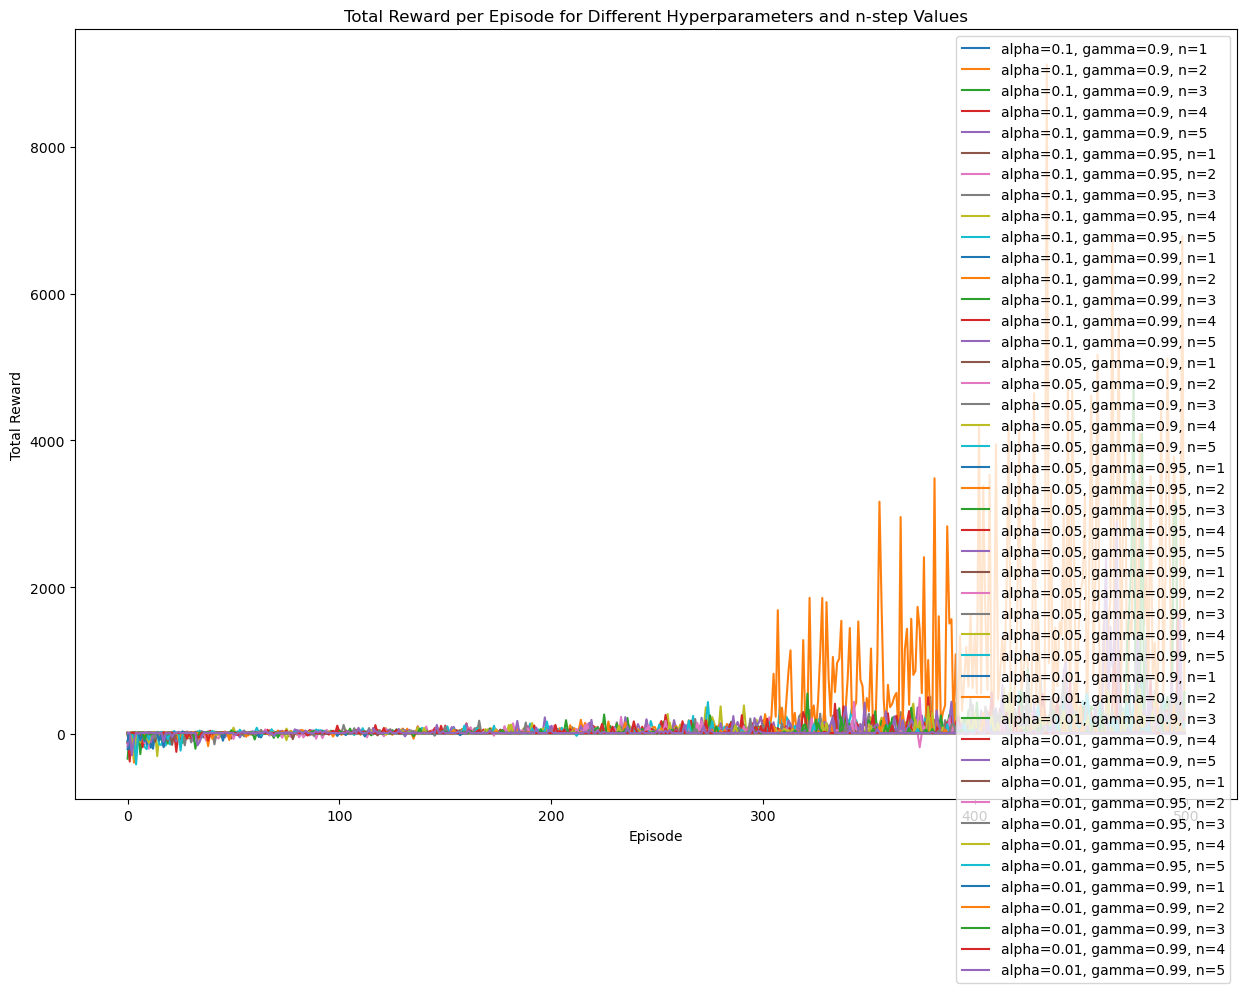

In [25]:
plt.figure(figsize=(15, 10))
for key, rewards in results.items():
    plt.plot(rewards, label=key)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode for Different Hyperparameters and n-step Values')
plt.legend()
plt.show()

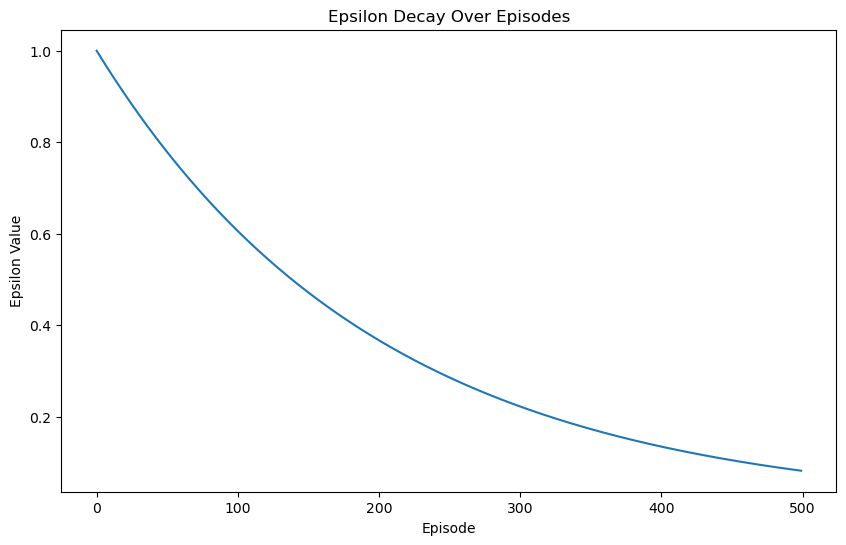

In [26]:
# Plot epsilon decay for one of the runs
plt.figure(figsize=(10, 6))
epsilon_values = [epsilon * (epsilon_decay ** i) for i in range(num_episodes)]
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Over Episodes')
plt.show()


In [27]:
for key, (initial_Q_A, initial_Q_B, trained_Q_A, trained_Q_B) in q_tables.items():
    print(f"\nResults for {key}:")
    print("Initial Q_A:\n", dict(initial_Q_A))
    print("Initial Q_B:\n", dict(initial_Q_B))
    print("Trained Q_A:\n", dict(trained_Q_A))
    print("Trained Q_B:\n", dict(trained_Q_B))


Results for alpha=0.1, gamma=0.9, n=1:
Initial Q_A:
 {}
Initial Q_B:
 {}
Trained Q_A:
 {(1, 0): array([ 0.63169101, -0.6248249 , -0.3202651 , -0.34988259]), (0, 0): array([6.47054578, 9.99999987, 5.62475049, 9.0488248 ]), (2, 0): array([-0.55158198, -0.70390765, -0.5063168 , -0.69190314]), (3, 0): array([-0.6921201 , -0.54525685, -0.85663803, -0.43098726]), (4, 0): array([-0.68968394, -0.83186234, -0.46198251, -1.49101839]), (3, 1): array([-0.43442701, -1.66609687, -0.38256068,  0.83002484]), (3, 2): array([-0.34248032, -0.309527  , -0.37400802,  5.10029367]), (4, 2): array([ 0.59920635, -0.57112112, -1.47620529,  1.98963757]), (4, 3): array([ 3.92974513e+00,  1.62526152e+00, -4.22912813e-03,  9.61847958e+00]), (3, 3): array([0.48254004, 5.36296607, 0.84422258, 1.83220464]), (2, 2): array([-0.46983913,  0.67702822, -0.64514876, -0.18625562]), (2, 3): array([-0.37508709,  3.72469713, -0.32262352, -0.03275238]), (2, 1): array([-0.40275684, -0.25163235, -0.67493855, -0.35747785]), (4, 1)

In [ ]:
# Run the environment for at least 10 episodes using only greedy actions for each value of n and plot the total reward per episode
greedy_rewards = {}
for n in n_values:
    trained_Q_A, trained_Q_B = q_tables[f'alpha=0.1, gamma=0.99, n={n}'][2:4]  # Use the trained Q-tables
    rewards_per_episode = []
    for episode in range(10):
        state = env.reset()
        done = False
        total_reward = 0
        step_count = 0  # To prevent infinite loops
        max_steps = 100  # Increase the number of steps per episode
        while not done and step_count < max_steps:
            action = np.argmax(trained_Q_A[state] + trained_Q_B[state])  # Greedy action selection
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            step_count += 1
        rewards_per_episode.append(total_reward)
    greedy_rewards[f'n={n}'] = rewards_per_episode

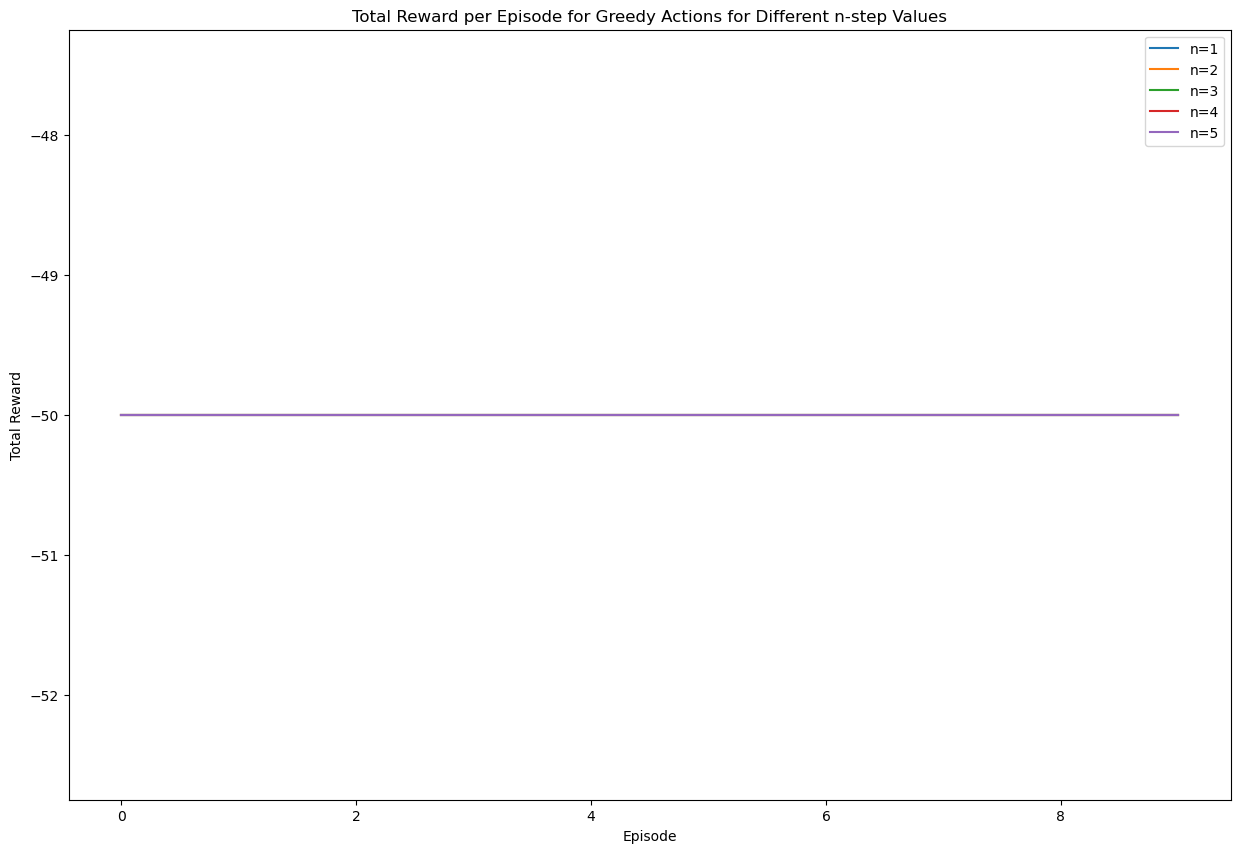

In [ ]:
# Plot total reward per episode for greedy actions
plt.figure(figsize=(15, 10))
for key, rewards in greedy_rewards.items():
    plt.plot(rewards, label=key)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode for Greedy Actions for Different n-step Values')
plt.legend()
plt.show()